In [1]:
pip install scikit-learn pandas matplotlib seaborn imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
DATA_PATH = "telecom_churn.csv"

In [3]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (100000, 12)


,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn,Timestamp
0,CUST000001,Male,0.0,Yes,Yes,26.0,Yes,Fiber optic,70.32,NaN,No,2021-10-26
1,CUST000002,Female,0.0,No,No,NaN,Yes,Fiber optic,47.88,2161.36,Yes,2022-04-03
2,CUST000003,Male,0.0,No,Yes,NaN,Yes,NaN,99.91,4224.95,Yes,2021-05-03
3,CUST000004,Male,NaN,No,No,44.0,Yes,DSL,29.44,1340.09,No,2021-08-18
4,CUST000005,NaN,0.0,No,Yes,29.0,NaN,Fiber optic,78.82,2280.05,No,2022-02-17


In [4]:
df.info()
df.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerID       100000 non-null  object 
 1   Gender           81787 non-null   object 
 2   SeniorCitizen    81861 non-null   float64
 3   Partner          81994 non-null   object 
 4   Dependents       82003 non-null   object 
 5   Tenure           82001 non-null   float64
 6   PhoneService     82096 non-null   object 
 7   InternetService  81579 non-null   object 
 8   MonthlyCharges   81904 non-null   float64
 9   TotalCharges     80257 non-null   object 
 10  Churn            100000 non-null  object 
 11  Timestamp        81757 non-null   object 
dtypes: float64(3), object(9)
memory usage: 9.2+ MB


TotalCharges       19743
InternetService    18421
Timestamp          18243
Gender             18213
SeniorCitizen      18139
MonthlyCharges     18096
Partner            18006
Tenure             17999
Dependents         17997
PhoneService       17904
CustomerID             0
Churn                  0
dtype: int64

In [5]:
for name in ["TotalCharges", "totalcharges", "total_charges"]:
    if name in df.columns:
        total_col = name
        break
else:
    raise KeyError("TotalCharges column not found")

mask_non_numeric = ~df[total_col].astype(str).str.replace(' ','').str.isnumeric()
print("Examples of problematic TotalCharges values (first 10):")
print(df.loc[mask_non_numeric, total_col].head(10))

df[total_col] = pd.to_numeric(df[total_col], errors='coerce')

print("Missing TotalCharges after conversion:", df[total_col].isna().sum())

display(df[df[total_col].isna()].head(10))

Examples of problematic TotalCharges values (first 10):
0        NaN
1    2161.36
2    4224.95
3    1340.09
4    2280.05
5    3448.78
6     1838.4
7    3101.47
8        NaN
9    4735.31
Name: TotalCharges, dtype: object
Missing TotalCharges after conversion: 20591


,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn,Timestamp
0,CUST000001,Male,0.0,Yes,Yes,26.0,Yes,Fiber optic,70.32,NaN,No,2021-10-26
8,CUST000009,Male,0.0,No,NaN,15.0,Yes,NaN,48.37,NaN,No,2022-11-25
16,CUST000017,Female,0.0,Yes,No,17.0,No,Fiber optic,61.14,NaN,Yes,2022-09-02
27,CUST000028,Female,0.0,No,Yes,55.0,Yes,No,NaN,NaN,No,2021-09-04
31,CUST000032,Male,0.0,Yes,No,11.0,Yes,Fiber optic,NaN,NaN,No,2022-08-07
36,CUST000037,Female,0.0,No,No,14.0,No,DSL,46.84,NaN,No,2022-04-10
39,CUST000040,Male,0.0,No,NaN,62.0,NaN,DSL,76.52,NaN,Yes,2020-02-07
44,CUST000045,Female,0.0,No,No,1.0,NaN,No,63.18,NaN,No,2022-01-18
46,CUST000047,NaN,0.0,No,No,30.0,Yes,DSL,78.71,NaN,No,2022-06-10
58,CUST000059,Male,0.0,No,No,48.0,NaN,NaN,95.26,NaN,No,2021-10-26


In [6]:
tenure_col = "tenure" if "tenure" in df.columns else "Tenure"
monthly_col = "MonthlyCharges" if "MonthlyCharges" in df.columns else "monthlycharges"

mask_fix = df[total_col].isna() & (df[tenure_col].notna()) & (df[monthly_col].notna())
df.loc[mask_fix, total_col] = df.loc[mask_fix, tenure_col] * df.loc[mask_fix, monthly_col]

print("Remaining missing TotalCharges:", df[total_col].isna().sum())

Remaining missing TotalCharges: 6706


In [7]:
missing = df.isna().mean().sort_values(ascending=False)
missing[missing>0]

InternetService    0.18421
Timestamp          0.18243
Gender             0.18213
SeniorCitizen      0.18139
MonthlyCharges     0.18096
Partner            0.18006
Tenure             0.17999
Dependents         0.17997
PhoneService       0.17904
TotalCharges       0.06706
dtype: float64

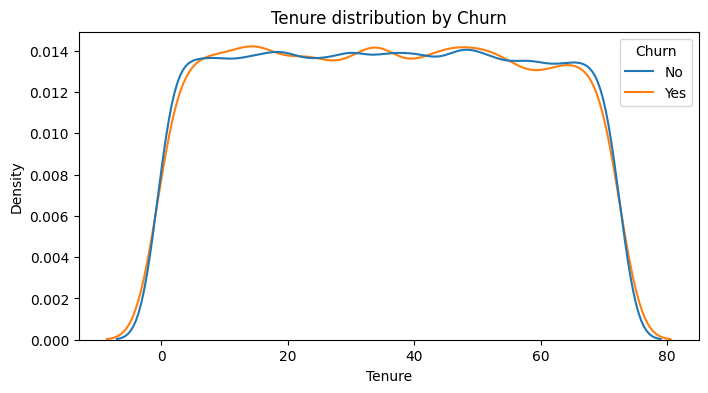

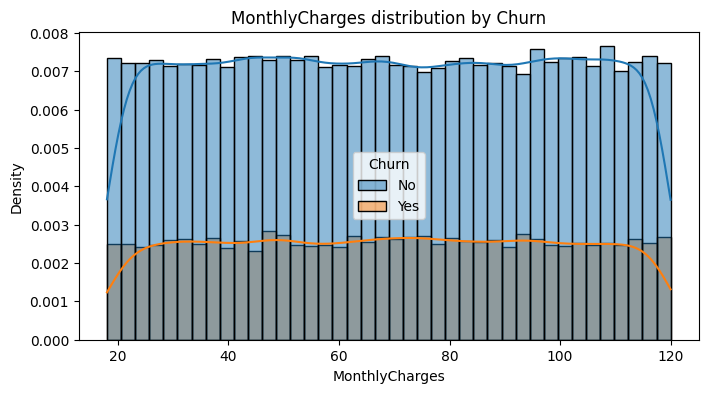

In [8]:
target_col = "Churn" if "Churn" in df.columns else "churn"
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x=tenure_col, hue=target_col, common_norm=False)
plt.title("Tenure distribution by Churn")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(data=df, x=monthly_col, hue=target_col, bins=40, kde=True, stat="density", alpha=0.5)
plt.title("MonthlyCharges distribution by Churn")
plt.show()

cat_example = "Contract" if "Contract" in df.columns else None
if cat_example:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=cat_example, hue=target_col)
    plt.title(f"{cat_example} vs Churn")
    plt.show()

In [9]:
service_cols = [c for c in df.columns if c.lower() in
                ("phoneservice", "multiplelines", "onlinesecurity", "onlinebackup",
                 "deviceprotection", "techsupport", "streamingtv", "streamingmovies",
                 "internetservice")]

def is_service_active(val):
    if pd.isna(val): 
        return 0
    if isinstance(val, str):
        val = val.strip().lower()
        if val in ("no", "no internet service", "none", "nointernet"):
            return 0
        else:
            return 1
    if val in (0, 1):
        return int(val)
    return 0

num_services = []
for idx, row in df.iterrows():
    cnt = 0
    for c in df.columns:
        lc = c.lower()
        if lc in ("phoneservice", "multiplelines", "onlinesecurity", "onlinebackup",
                  "deviceprotection", "techsupport", "streamingtv", "streamingmovies"):
            cnt += is_service_active(row[c])
    if "InternetService" in df.columns:
        cnt += 0 if str(row["InternetService"]).strip().lower() in ("no", "no internet service", "none") else 1
    num_services.append(cnt)

df["NumServices"] = num_services

df["AvgChargePerService"] = df[monthly_col] / (df["NumServices"] + 1e-6)

df[["NumServices", "AvgChargePerService", monthly_col, tenure_col, total_col]].head()

,NumServices,AvgChargePerService,MonthlyCharges,Tenure,TotalCharges
0,2,35.159982,70.32,26.0,1828.32
1,2,23.939988,47.88,NaN,2161.36
2,2,49.954975,99.91,NaN,4224.95
3,2,14.719993,29.44,44.0,1340.09
4,1,78.819921,78.82,29.0,2280.05


In [10]:
drop_cols = [c for c in df.columns if c.lower() in ("customerid", "customer_id", "timestamp")]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

df[target_col] = df[target_col].map({"Yes":1, "No":0}) if df[target_col].dtype == object else df[target_col]

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

numeric_feats = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_feats = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

for c in ["NumServices", "AvgChargePerService"]:
    if c in numeric_feats and c in categorical_feats:
        categorical_feats.remove(c)

print("Numeric features:", numeric_feats)
print("Categorical features:", categorical_feats)

Numeric features: ['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges', 'NumServices', 'AvgChargePerService']
Categorical features: ['Gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService']


In [11]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_feats),
    ("cat", categorical_transformer, categorical_feats)
], remainder="drop")

In [12]:
clf_lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight="balanced")

pipeline_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", clf_lr)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=RANDOM_STATE)

pipeline_lr.fit(X_train, y_train)
print("Trained LogisticRegression pipeline")

Trained LogisticRegression pipeline


In [13]:
pipe_lr = Pipeline([("preprocessor", preprocessor),
                    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])

pipe_rf = Pipeline([("preprocessor", preprocessor),
                    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])

pipe_gb = Pipeline([("preprocessor", preprocessor),
                    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))])

In [14]:
from sklearn.model_selection import cross_val_score

for name, pipe in [("LogisticRegression", pipe_lr), ("RandomForest", pipe_rf), ("GradientBoosting", pipe_gb)]:
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="f1_weighted", n_jobs=-1)
    print(f"{name} f1_weighted CV: mean={scores.mean():.4f} std={scores.std():.4f}")

LogisticRegression f1_weighted CV: mean=0.6288 std=0.0000
RandomForest f1_weighted CV: mean=0.6391 std=0.0012
GradientBoosting f1_weighted CV: mean=0.6287 std=0.0000


In [15]:
param_grid = {
    "clf__n_estimators": [100, 300],
    "clf__max_depth": [None, 8, 16],
    "clf__min_samples_split": [2, 5],
    "clf__class_weight": [None, "balanced"]
}

grid_rf = GridSearchCV(pipe_rf, param_grid, cv=4, scoring="f1_weighted", n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print("Best params:", grid_rf.best_params_)
print("Best CV f1_weighted:", grid_rf.best_score_)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best params: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Best CV f1_weighted: 0.6387520652138877


In [16]:
from imblearn.over_sampling import SMOTE

imb_pipe_rf = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_imb = {
    "clf__n_estimators": [100, 300],
    "clf__max_depth": [None, 12],
}

grid_imb = GridSearchCV(imb_pipe_rf, param_grid_imb, cv=4, scoring="f1_weighted", n_jobs=-1, verbose=1)
grid_imb.fit(X_train, y_train)

print("Best params (SMOTE):", grid_imb.best_params_)
print("Best CV f1_weighted (SMOTE):", grid_imb.best_score_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best params (SMOTE): {'clf__max_depth': None, 'clf__n_estimators': 300}
Best CV f1_weighted (SMOTE): 0.6105067277960754


In [17]:
best_model = None
if grid_imb.best_score_ >= grid_rf.best_score_:
    best_model = grid_imb.best_estimator_
    print("Selected model: RF with SMOTE")
else:
    best_model = grid_rf.best_estimator_
    print("Selected model: RF without SMOTE (maybe class_weight used)")

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else None

print("Classification report (test):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

if y_proba is not None:
    auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC:", auc)

Selected model: RF without SMOTE (maybe class_weight used)
Classification report (test):
              precision    recall  f1-score   support

           0     0.7400    0.8987    0.8116     14791
           1     0.2641    0.1033    0.1485      5209

    accuracy                         0.6915     20000
   macro avg     0.5020    0.5010    0.4801     20000
weighted avg     0.6160    0.6915    0.6389     20000

Confusion matrix:
 [[13292  1499]
 [ 4671   538]]
ROC AUC: 0.5049213447822212


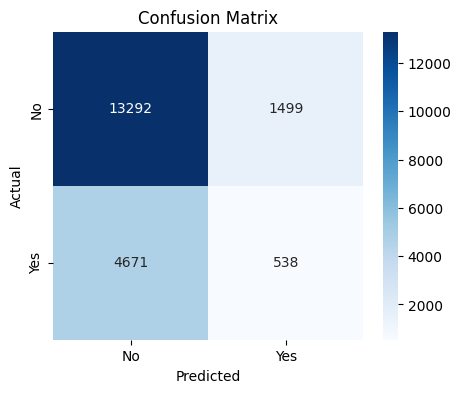

In [18]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

,feature,importance
3,TotalCharges,0.311887
2,MonthlyCharges,0.233283
5,AvgChargePerService,0.190805
1,Tenure,0.190618
0,SeniorCitizen,0.012098
4,NumServices,0.008682
11,Dependents_Yes,0.005926
10,Dependents_No,0.005775
9,Partner_Yes,0.005648
8,Partner_No,0.005587


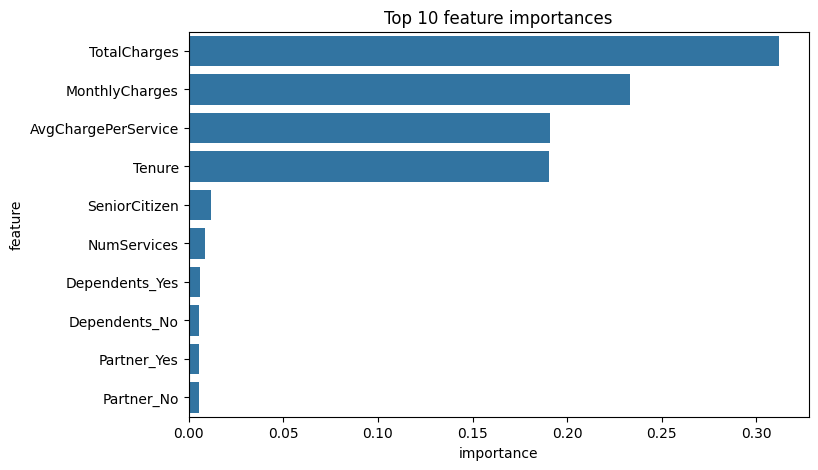

In [19]:
def get_feature_names_from_coltransformer(col_transformer):
    num_names = numeric_feats
    cat_names = []
    ohe = None
    for name, trans, cols in col_transformer.transformers_:
        if name == "cat":
            ohe = trans.named_steps["ohe"]
            cat_cols = cols
            break
    if ohe is not None:
        ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
        cat_names = list(ohe_names)
    return num_names + cat_names

if isinstance(best_model.named_steps.get("clf"), (RandomForestClassifier, GradientBoostingClassifier)):
    ct = best_model.named_steps["preprocessor"]
    feat_names = get_feature_names_from_coltransformer(ct)
    importances = best_model.named_steps["clf"].feature_importances_
    feat_imp = pd.DataFrame({"feature": feat_names, "importance": importances})
    feat_imp = feat_imp.sort_values("importance", ascending=False).head(10)
    display(feat_imp)
    plt.figure(figsize=(8,5))
    sns.barplot(data=feat_imp, x="importance", y="feature")
    plt.title("Top 10 feature importances")
    plt.show()
else:
    print("Final model is not tree-based — skip feature importances.")